In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from utils.TD_NN import TemporalDifferenceNN
from utils.NeuralNet import TwoHiddenLayerNN

from utils import Benchmarking

# seed = 42
# torch.manual_seed(seed)

In [2]:
housedata = torch.tensor(np.loadtxt('data\\readyhousedata.txt', delimiter=','), dtype=torch.float32)

X = housedata[:, :-1]
y = housedata[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Parameters for TD
num_samples, num_features = X_train.shape
num_samples_test, num_features_test = X_test.shape
P = torch.ones((num_samples, num_samples)) / num_samples # Equal probability to move to any state

identity = lambda x : x

In [4]:
num_samples

404

In [5]:
# Initialise classes
td_sgd = TemporalDifferenceNN(
    optimizer='sgd',
    input_size=num_features,
    learning_rate=0.001,
    epsilon=1e-7,
    n_iter=1e6,
    P=P,
)

td_adam = TemporalDifferenceNN(
    optimizer='adam',
    input_size=num_features,
    learning_rate=0.01,
    epsilon=1e-7,
    n_iter=1e6,
    P=P,
    betas=(0.85, 0.999),
)

nn_sgd = TwoHiddenLayerNN(
    input_size=num_features,
    optimizer='sgd',
    learning_rate=0.001,
)

nn_adam = TwoHiddenLayerNN(
    input_size=num_features,
    optimizer='adam',
    learning_rate=0.001,
)

In [6]:
# Train the TD models
td_sgd.fit(X_train, y_train)
td_adam.fit(X_train, y_train)

# Train the NN models
nn_sgd.fit(X_train, y_train, epochs=1600)
nn_adam.fit(X_train, y_train, epochs=1600)

Ending optimization early at iteration 15669
Ending optimization early at iteration 17460


In [7]:
iter = int(5e4)
# Define noise standard deviation
noise_std = 0.1

# Initialize tensors to store predictions over iterations
y_pred_td_sgd = td_sgd.predict(X_test)
y_pred_td_adam = td_adam.predict(X_test)
y_pred_nn_sgd = nn_sgd.predict(X_test)
y_pred_nn_adam = nn_adam.predict(X_test)

Y_pred_td_sgd_noisy = torch.zeros(num_samples_test, iter)
Y_pred_td_adam_noisy = torch.zeros(num_samples_test, iter)
Y_pred_nn_sgd_noisy = torch.zeros(num_samples_test, iter)
Y_pred_nn_adam_noisy = torch.zeros(num_samples_test, iter)

# Add Gaussian noise to the test set
for i in range(iter):
    X_test_noisy = X_test + torch.randn(X_test.shape) * noise_std
    
    # TD predictions on original and noisy test sets
    Y_pred_td_sgd_noisy[:, i] = td_sgd.predict(X_test_noisy).squeeze()
    Y_pred_td_adam_noisy[:, i] = td_adam.predict(X_test_noisy).squeeze()

    # NN predictions on original and noisy test sets
    Y_pred_nn_sgd_noisy[:, i] = nn_sgd.predict(X_test_noisy).squeeze()
    Y_pred_nn_adam_noisy[:, i] = nn_adam.predict(X_test_noisy).squeeze()


In [8]:
change_td_sgd = Benchmarking.mean_absolute_diff(y_pred_td_sgd, Y_pred_td_sgd_noisy)
change_td_adam = Benchmarking.mean_absolute_diff(y_pred_td_adam, Y_pred_td_adam_noisy)
change_nn_sgd = Benchmarking.mean_absolute_diff(y_pred_nn_sgd, Y_pred_nn_sgd_noisy)
change_nn_adam = Benchmarking.mean_absolute_diff(y_pred_nn_adam, Y_pred_nn_adam_noisy)

# Print the results
print(f"Average change for TD-SGD: {torch.mean(change_td_sgd)} ± {torch.std(change_td_sgd)}")
print(f"Average change for TD-Adam: {torch.mean(change_td_adam)} ± {torch.std(change_td_adam)}")
print(f"Average change for L2-SGD: {torch.mean(change_nn_sgd)} ± {torch.std(change_nn_sgd)}")
print(f"Average change for L2-Adam: {torch.mean(change_nn_adam)} ± {torch.std(change_nn_adam)}")

Average change for TD-SGD: 2.324934482574463 ± 0.2326093316078186
Average change for TD-Adam: 4.226555347442627 ± 0.4101737141609192
Average change for L2-SGD: 3.244267463684082 ± 0.2793884575366974
Average change for L2-Adam: 3.6070497035980225 ± 0.3111913800239563


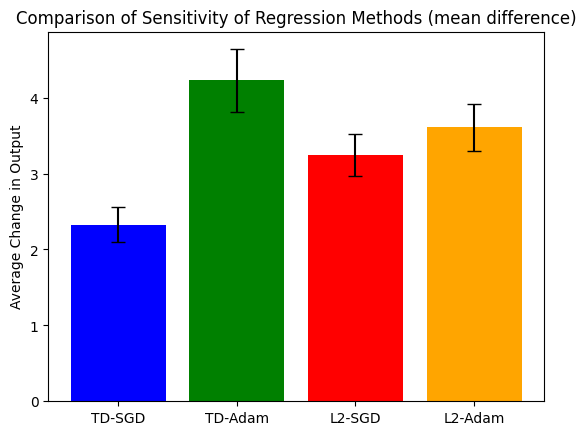

In [9]:
# Plot the changes in predictions
Benchmarking.plot_noise_diff(
    td_sgd=change_td_sgd, 
    td_adam=change_td_adam, 
    nn_sgd=change_nn_sgd, 
    nn_adam=change_nn_adam,
    )

In [10]:
print(f"RMSE for TD-SGD {td_sgd.rmse(X_test, y_test)}")
print(f"RMSE for TD-ADAM {td_adam.rmse(X_test, y_test)}")
print(f"RMSE for L2-SGD {nn_sgd.rmse(X_test, y_test)}")
print(f"RMSE for L2-ADAM {nn_adam.rmse(X_test, y_test)}")

RMSE for TD-SGD 3.058527708053589
RMSE for TD-ADAM 3.0123162269592285
RMSE for L2-SGD 2.936643362045288
RMSE for L2-ADAM 2.9739644527435303


In [11]:
print(f"RMSE for noisy TD-SGD {td_sgd.rmse(X_test_noisy, y_test)}")
print(f"RMSE for noisy TD-ADAM {td_adam.rmse(X_test_noisy, y_test)}")
print(f"RMSE for noisy L2-SGD {nn_sgd.rmse(X_test_noisy, y_test)}")
print(f"RMSE for noisy L2-ADAM {nn_adam.rmse(X_test_noisy, y_test)}")

RMSE for noisy TD-SGD 5.0085272789001465
RMSE for noisy TD-ADAM 6.652289867401123
RMSE for noisy L2-SGD 5.572878360748291
RMSE for noisy L2-ADAM 5.9383320808410645


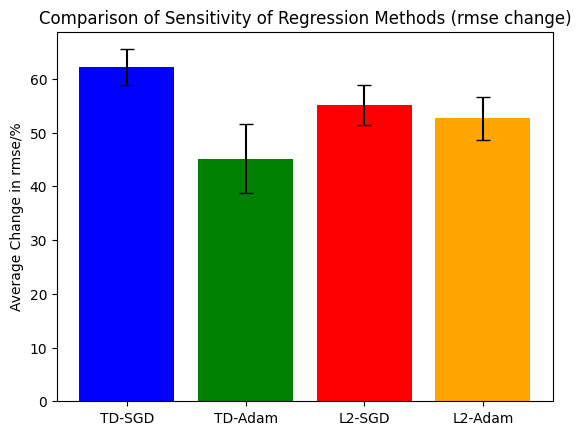

In [12]:
rmse_change_td_sgd =  Benchmarking.mean_rmse_change(y_test, y_pred_td_sgd, Y_pred_td_sgd_noisy)
rmse_change_td_adam = Benchmarking.mean_rmse_change(y_test, y_pred_td_adam, Y_pred_td_adam_noisy)
rmse_change_nn_sgd =  Benchmarking.mean_rmse_change(y_test, y_pred_nn_sgd, Y_pred_nn_sgd_noisy)
rmse_change_nn_adam = Benchmarking.mean_rmse_change(y_test, y_pred_nn_adam, Y_pred_nn_adam_noisy)

# Plot the changes in predictions
Benchmarking.plot_rmse_diff(
    td_sgd=rmse_change_td_sgd, 
    td_adam=rmse_change_td_adam, 
    nn_sgd=rmse_change_nn_sgd, 
    nn_adam=rmse_change_nn_adam,
    )